# 📊 Phase A: Reasoning Subspace Analysis

This notebook visualizes the learned reasoning subspace from Phase A.

**Data Source:** `vm_results/Qwen2.5-7B-Instruct__qwen_causality_v3/mmlu_pro/`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 10),
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})
COLORS = {'primary': '#2E86AB', 'secondary': '#A23B72', 'accent': '#F18F01', 'correct': '#2D936C', 'incorrect': '#D64045'}

DATA_DIR = Path('../../vm_results/Qwen2.5-7B-Instruct__qwen_causality_v3/mmlu_pro')
OUTPUT_DIR = Path('../outputs/phase_a')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Data exists: {DATA_DIR.exists()}')

Data exists: True


In [2]:
# Load all data
metrics_df = pd.read_csv(DATA_DIR / 'screening' / 'metrics_flat.csv').sort_values('layer_idx')
pooled = np.load(DATA_DIR / 'pooled.npz')
X, layers = pooled['X'], pooled['layers']
labels = np.load(DATA_DIR / 'labels.npy')
directions = np.load(DATA_DIR / 'screening' / 'layer_to_U.npz')
gen_df = pd.read_csv(DATA_DIR / 'generations_with_judgments.csv')
print(f'Metrics: {len(metrics_df)} layers, Activations: {X.shape}, Labels: {labels.shape}')

Metrics: 20 layers, Activations: (100, 20, 3584), Labels: (100,)


## 1. Probe Performance by Layer

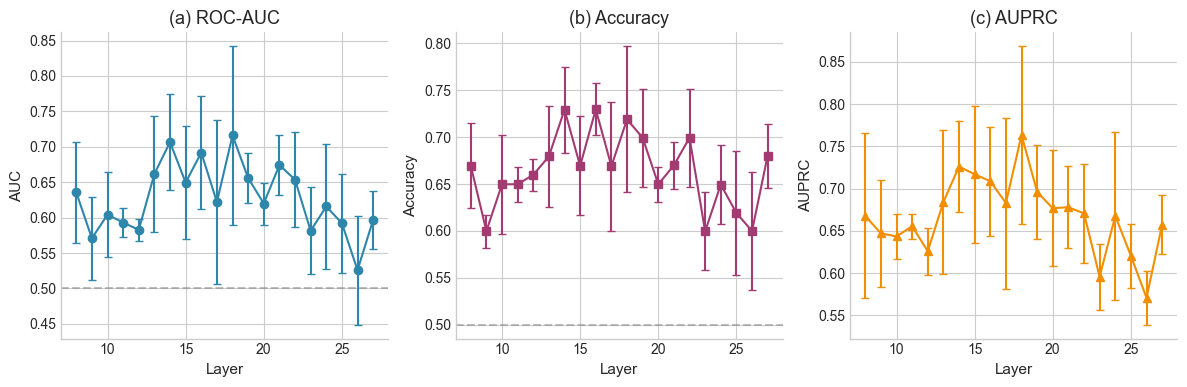

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
layer_idxs = metrics_df['layer_idx'].values

axes[0].errorbar(layer_idxs, metrics_df['auc'], yerr=metrics_df['std_auc'], fmt='o-', color=COLORS['primary'], capsize=3)
axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].set(xlabel='Layer', ylabel='AUC', title='(a) ROC-AUC')

axes[1].errorbar(layer_idxs, metrics_df['acc'], yerr=metrics_df['std_acc'], fmt='s-', color=COLORS['secondary'], capsize=3)
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set(xlabel='Layer', ylabel='Accuracy', title='(b) Accuracy')

axes[2].errorbar(layer_idxs, metrics_df['auprc'], yerr=metrics_df['std_auprc'], fmt='^-', color=COLORS['accent'], capsize=3)
axes[2].set(xlabel='Layer', ylabel='AUPRC', title='(c) AUPRC')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'probe_metrics_by_layer.pdf')
plt.show()

## 2. Layer Score Ranking

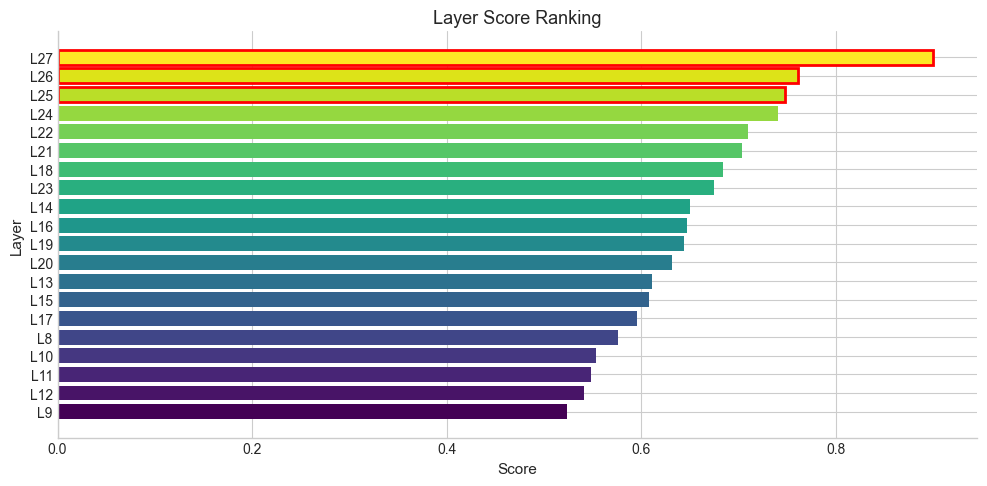

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
sorted_df = metrics_df.sort_values('score', ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_df)))
bars = ax.barh([f'L{int(l)}' for l in sorted_df['layer_idx']], sorted_df['score'], color=colors)
for bar in bars[-3:]: bar.set_edgecolor('red'); bar.set_linewidth(2)
ax.set(xlabel='Score', ylabel='Layer', title='Layer Score Ranking')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'layer_score_ranking.pdf')
plt.show()

## 3. Delta-mu vs AUC

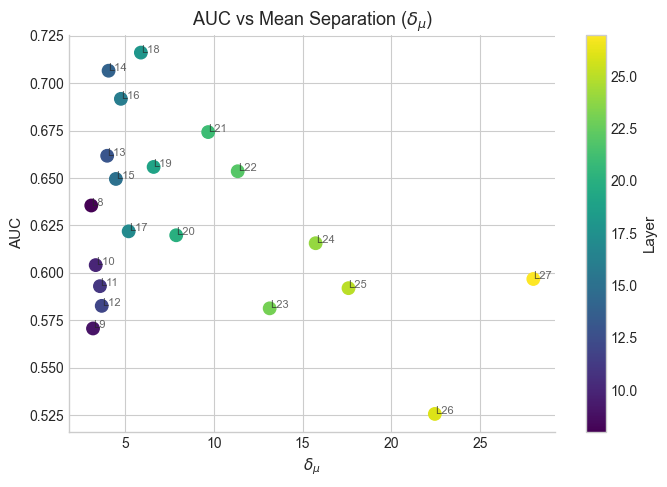

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(metrics_df['delta_mu'], metrics_df['auc'], c=metrics_df['layer_idx'], cmap='viridis', s=80)
for _, r in metrics_df.iterrows():
    ax.annotate(f'L{int(r["layer_idx"])}', (r['delta_mu'], r['auc']), fontsize=8, alpha=0.7)
ax.set(xlabel=r'$\delta_\mu$', ylabel='AUC', title=r'AUC vs Mean Separation ($\delta_\mu$)')
plt.colorbar(sc, label='Layer')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'delta_mu_vs_auc.pdf')
plt.show()

## 4. Metrics Correlation

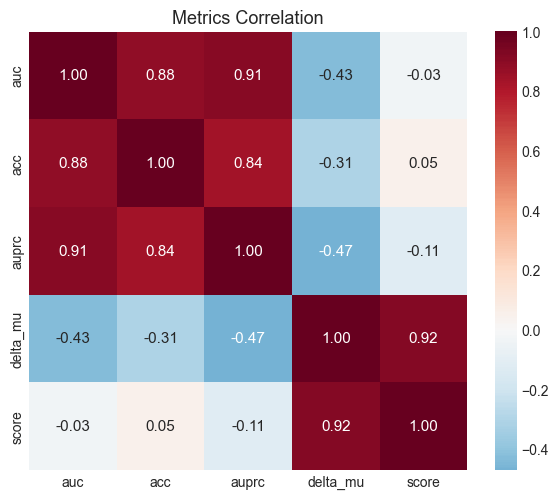

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))
corr = metrics_df[['auc', 'acc', 'auprc', 'delta_mu', 'score']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, square=True)
ax.set_title('Metrics Correlation')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'metrics_correlation.pdf')
plt.show()

## 5. t-SNE of Best Layer

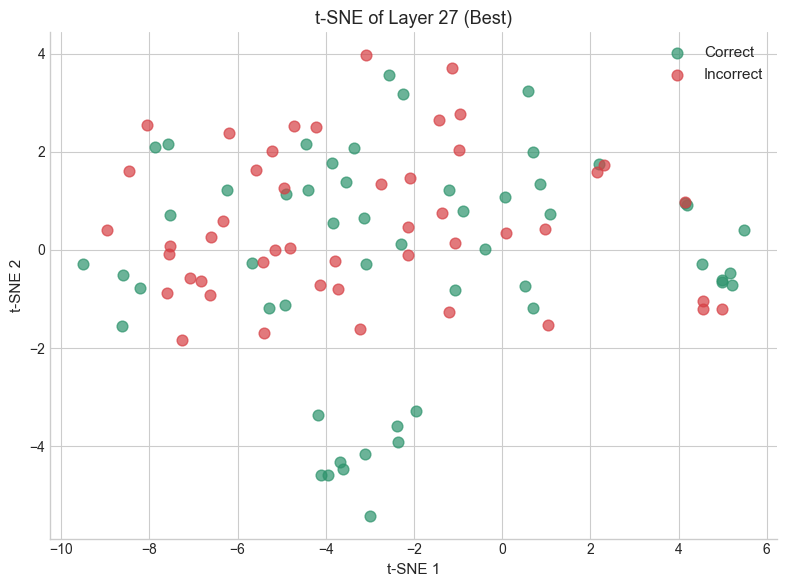

In [7]:
best_layer = int(metrics_df.loc[metrics_df['score'].idxmax(), 'layer_idx'])
layer_pos = np.where(layers == best_layer)[0][0]
X_layer = X[:, layer_pos, :]

fig, ax = plt.subplots(figsize=(8, 6))
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_layer)-1))
X_tsne = tsne.fit_transform(X_layer)

for label, color, name in [(1, COLORS['correct'], 'Correct'), (0, COLORS['incorrect'], 'Incorrect')]:
    mask = labels == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, s=60, alpha=0.7, label=name)
ax.set(xlabel='t-SNE 1', ylabel='t-SNE 2', title=f't-SNE of Layer {best_layer} (Best)')
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'tsne_best_layer.pdf')
plt.show()

## 6. PCA of Top 3 Layers

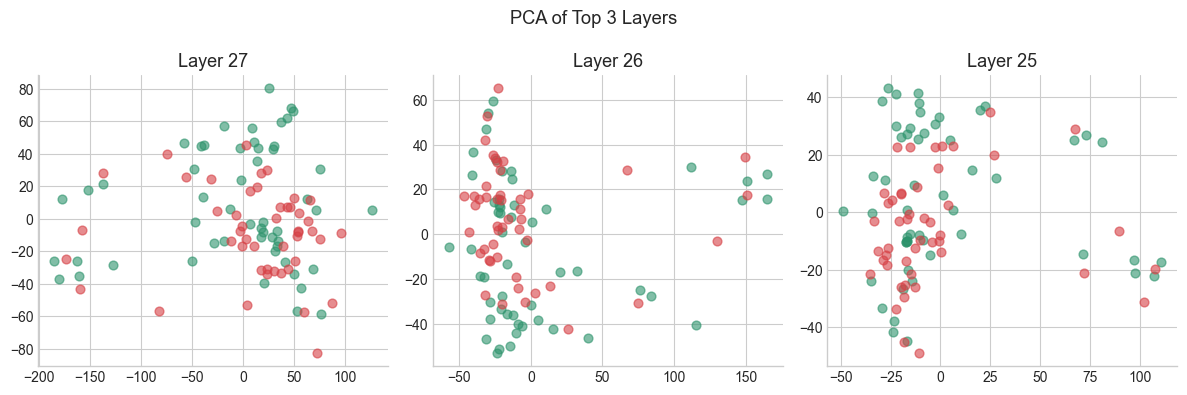

In [8]:
top_layers = metrics_df.nlargest(3, 'score')['layer_idx'].values
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, layer_idx in enumerate(top_layers):
    layer_pos = np.where(layers == layer_idx)[0][0]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X[:, layer_pos, :])
    for label, color in [(1, COLORS['correct']), (0, COLORS['incorrect'])]:
        axes[i].scatter(X_pca[labels==label, 0], X_pca[labels==label, 1], c=color, s=40, alpha=0.6)
    axes[i].set_title(f'Layer {int(layer_idx)}')

plt.suptitle('PCA of Top 3 Layers')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pca_top_layers.pdf')
plt.show()

## 7. Direction Analysis

Available direction keys: ['L25', 'L26', 'L27']


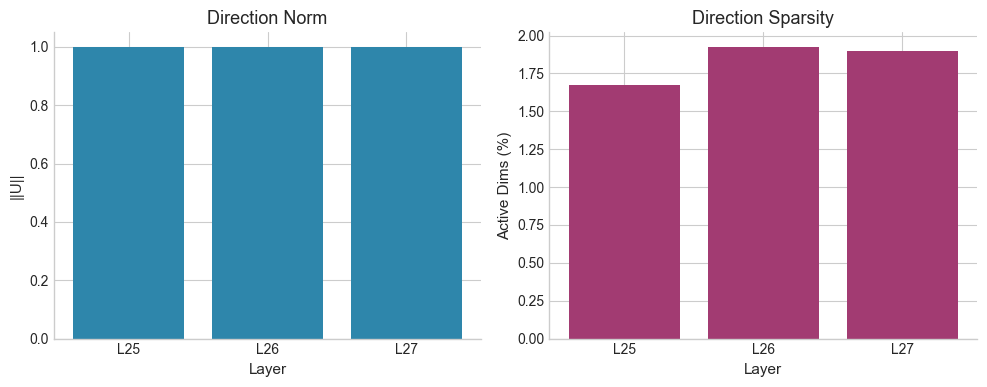

In [9]:
# Get available direction keys
direction_keys = list(directions.keys())
print(f'Available direction keys: {direction_keys}')

# Helper to extract layer number from key (handles 'L25' or '25' format)
def get_layer_num(key):
    s = str(key)
    return int(s.replace('L', '').replace('l', ''))

stats = []
for key in direction_keys:
    U = directions[key].flatten() if directions[key].ndim > 1 else directions[key]
    stats.append({'layer': str(key), 'layer_int': get_layer_num(key), 'norm': np.linalg.norm(U), 'sparsity': np.mean(np.abs(U) > 0.01*np.max(np.abs(U)))})
stats_df = pd.DataFrame(stats).sort_values('layer_int')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(stats_df['layer'], stats_df['norm'], color=COLORS['primary'])
axes[0].set(xlabel='Layer', ylabel='||U||', title='Direction Norm')
axes[1].bar(stats_df['layer'], stats_df['sparsity']*100, color=COLORS['secondary'])
axes[1].set(xlabel='Layer', ylabel='Active Dims (%)', title='Direction Sparsity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'direction_sparsity.pdf')
plt.show()

## 8. Top Direction Components

Using layer L27 for direction analysis


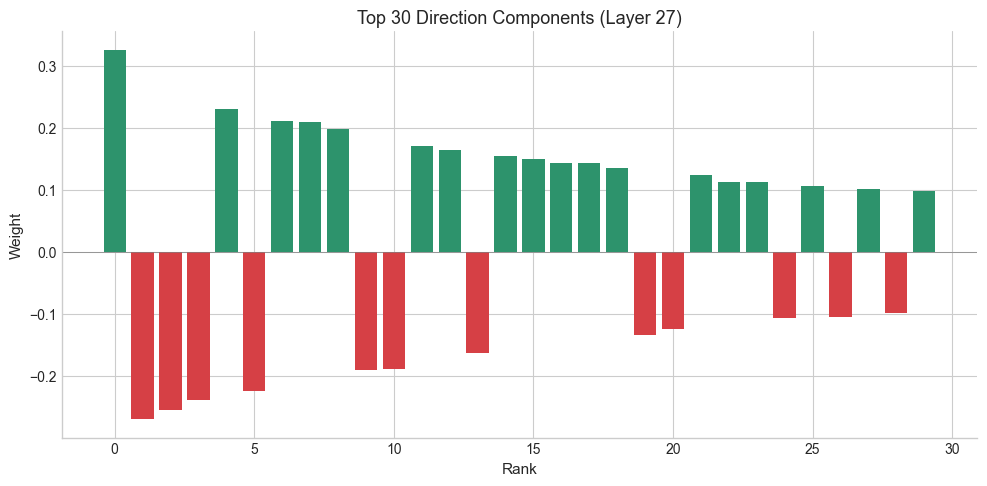

In [10]:
# Find best layer that exists in directions (handles both '25' and 'L25' formats)
best_layer_key = None
for key in direction_keys:
    if get_layer_num(key) == best_layer:
        best_layer_key = key
        break
if best_layer_key is None:
    print(f'Best layer {best_layer} not in directions, using first available: {direction_keys[0]}')
    best_layer_key = direction_keys[0]

U = directions[best_layer_key].flatten() if directions[best_layer_key].ndim > 1 else directions[best_layer_key]
sorted_idx = np.argsort(np.abs(U))[::-1][:30]
print(f'Using layer {best_layer_key} for direction analysis')

fig, ax = plt.subplots(figsize=(10, 5))
colors = [COLORS['correct'] if U[i] > 0 else COLORS['incorrect'] for i in sorted_idx]
ax.bar(range(30), U[sorted_idx], color=colors)
ax.axhline(0, color='gray', linewidth=0.5)
ax.set(xlabel='Rank', ylabel='Weight', title=f'Top 30 Direction Components (Layer {best_layer})')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'top_k_dimensions.pdf')
plt.show()

## 9. Reasoning vs Answer Correctness

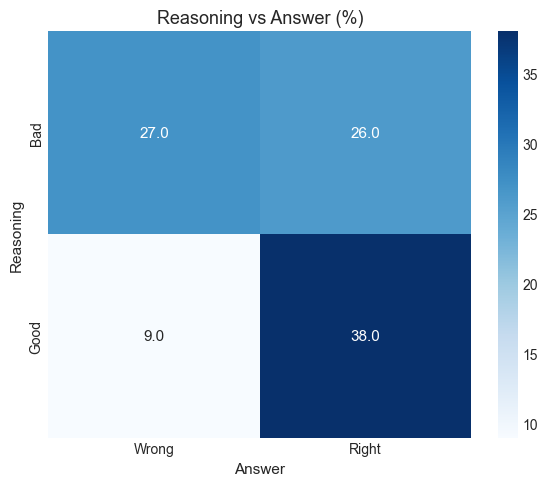

In [11]:
if 'reasoning_correct_judge' in gen_df.columns:
    fig, ax = plt.subplots(figsize=(6, 5))
    conf = np.zeros((2, 2))
    for r, a in zip(gen_df['reasoning_correct_judge'].astype(int), gen_df['answer_correct_judge'].astype(int)):
        conf[1-r, 1-a] += 1
    sns.heatmap(conf/conf.sum()*100, annot=True, fmt='.1f', cmap='Blues', ax=ax,
                xticklabels=['Wrong', 'Right'], yticklabels=['Bad', 'Good'])
    ax.set(xlabel='Answer', ylabel='Reasoning', title='Reasoning vs Answer (%)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'reasoning_vs_answer.pdf')
    plt.show()

## 10. Summary Dashboard

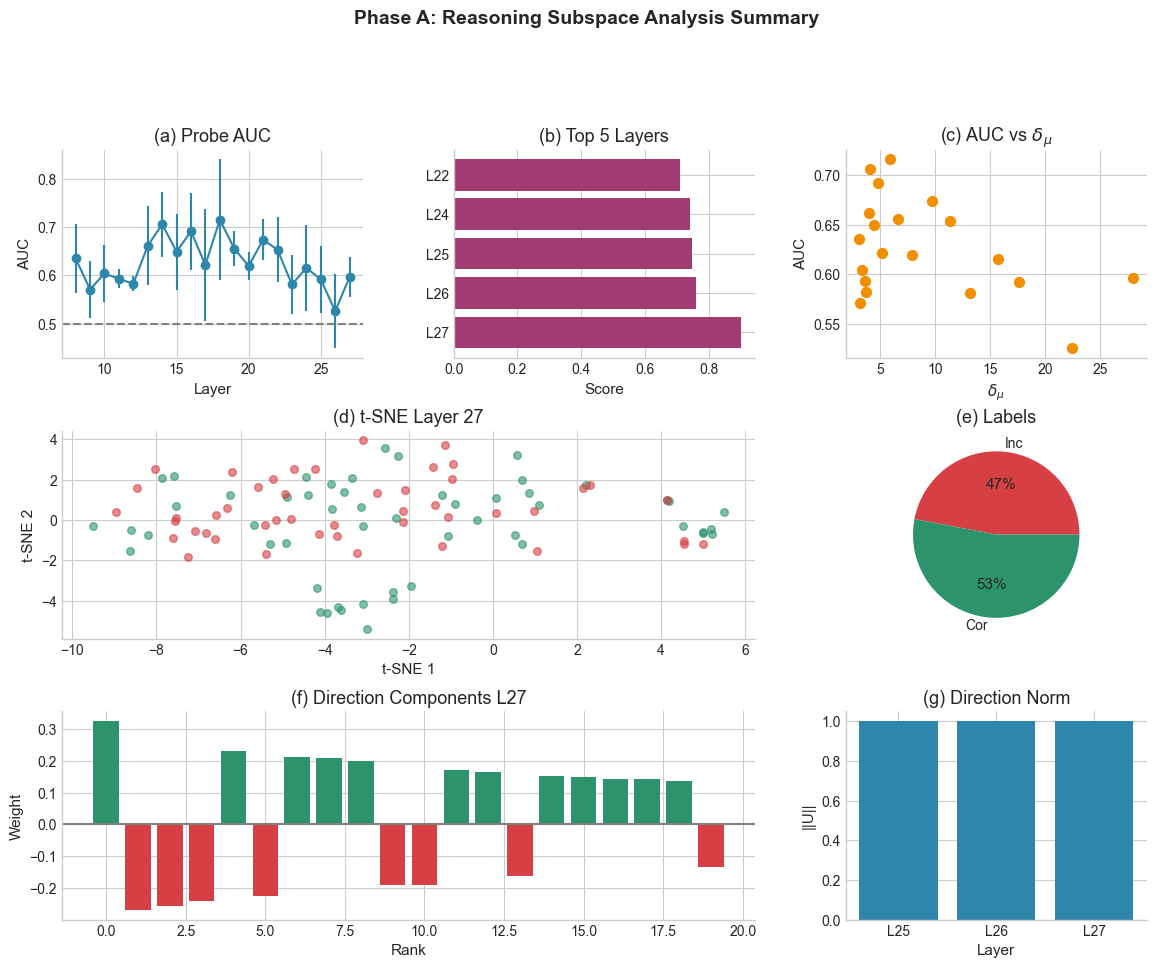

All figures saved to ../outputs/phase_a


In [12]:
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

# AUC by layer
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(metrics_df['layer_idx'], metrics_df['auc'], yerr=metrics_df['std_auc'], fmt='o-', color=COLORS['primary'])
ax1.axhline(0.5, color='gray', linestyle='--')
ax1.set(xlabel='Layer', ylabel='AUC', title='(a) Probe AUC')

# Top 5
ax2 = fig.add_subplot(gs[0, 1])
top5 = metrics_df.nlargest(5, 'score')
ax2.barh([f'L{int(l)}' for l in top5['layer_idx']], top5['score'], color=COLORS['secondary'])
ax2.set(xlabel='Score', title='(b) Top 5 Layers')

# Delta-mu vs AUC
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(metrics_df['delta_mu'], metrics_df['auc'], c=COLORS['accent'], s=50)
ax3.set(xlabel=r'$\delta_\mu$', ylabel='AUC', title=r'(c) AUC vs $\delta_\mu$')

# t-SNE
ax4 = fig.add_subplot(gs[1, 0:2])
for label, color in [(1, COLORS['correct']), (0, COLORS['incorrect'])]:
    ax4.scatter(X_tsne[labels==label, 0], X_tsne[labels==label, 1], c=color, s=30, alpha=0.6)
ax4.set(xlabel='t-SNE 1', ylabel='t-SNE 2', title=f'(d) t-SNE Layer {best_layer}')

# Class balance
ax5 = fig.add_subplot(gs[1, 2])
ax5.pie(np.bincount(labels.astype(int)), labels=['Inc', 'Cor'], autopct='%1.0f%%', colors=[COLORS['incorrect'], COLORS['correct']])
ax5.set_title('(e) Labels')

# Direction components
ax6 = fig.add_subplot(gs[2, 0:2])
ax6.bar(range(20), U[sorted_idx[:20]], color=[COLORS['correct'] if U[i]>0 else COLORS['incorrect'] for i in sorted_idx[:20]])
ax6.axhline(0, color='gray')
ax6.set(xlabel='Rank', ylabel='Weight', title=f'(f) Direction Components L{best_layer}')

# Norm
ax7 = fig.add_subplot(gs[2, 2])
ax7.bar(stats_df['layer'], stats_df['norm'], color=COLORS['primary'])
ax7.set(xlabel='Layer', ylabel='||U||', title='(g) Direction Norm')

plt.suptitle('Phase A: Reasoning Subspace Analysis Summary', fontsize=14, fontweight='bold', y=1.02)
plt.savefig(OUTPUT_DIR / 'summary_dashboard.pdf', bbox_inches='tight')
plt.show()
print(f'All figures saved to {OUTPUT_DIR}')

## Summary

In [13]:
print('='*60)
print('PHASE A ANALYSIS SUMMARY')
print('='*60)
top3 = metrics_df.nlargest(3, 'score')
print('\nTop 3 Layers:')
for i, (_, r) in enumerate(top3.iterrows(), 1):
    print(f'  {i}. L{int(r["layer_idx"])}: Score={r["score"]:.3f}, AUC={r["auc"]:.3f}')
print(f'\nMean AUC: {metrics_df["auc"].mean():.3f} +/- {metrics_df["auc"].std():.3f}')
print(f'Best layer: {best_layer}')

PHASE A ANALYSIS SUMMARY

Top 3 Layers:
  1. L27: Score=0.900, AUC=0.597
  2. L26: Score=0.761, AUC=0.526
  3. L25: Score=0.747, AUC=0.592

Mean AUC: 0.627 +/- 0.049
Best layer: 27
